In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score



In [210]:
pdf_valuations = pd.read_csv('data/input/player_valuations.csv')[["player_id", "date", "market_value_in_eur"]]
pdf_players = pd.read_csv('data/input/players.csv')[["player_id", "name", "date_of_birth", "position", "sub_position", "contract_expiration_date", "current_club_name", "current_club_domestic_competition_id" ]]

In [ ]:
pdf_joined = pdf_players.merge(pdf_valuations, on="player_id").query("current_club_domestic_competition_id == 'GB1'")
pdf_joined["age"] = (pd.to_datetime(pdf_joined["date"]) - pd.to_datetime(pdf_joined["date_of_birth"])).dt.days // 365
pdf_joined["year"] = pd.to_datetime(pdf_joined["date"]).dt.year
pdf_joined["month"] = pd.to_datetime(pdf_joined["date"]).dt.month

pdf_joined["market_value_in_million_eur"] = pdf_joined["market_value_in_eur"] / 1000000

In [213]:
pdf_mvp = pdf_joined[["name", "player_id", "date_of_birth", "date", "market_value_in_million_eur", "age", "year", "month" ]]

In [214]:
# Filter training and test sets
train = pdf_mvp[pdf_mvp["year"] <= 2022].sort_values("date", ascending=False)
test = pdf_mvp[(pdf_mvp["year"] >= 2023)].sort_values("date", ascending=False)

In [215]:
pdf_train_agg= train.query("year == 2022").groupby(["player_id", "name"])[["date_of_birth", "market_value_in_million_eur", "age"]].first().reset_index()

In [216]:
pdf_test_agg = test.query("year == 2023").groupby(["player_id", "name"])[["date_of_birth", "market_value_in_million_eur", "age"]].last().reset_index()

In [217]:
pdf_test_train = pdf_train_agg.merge(pdf_test_agg, on=["player_id", "name"], suffixes=("_train", "_test"))

In [ ]:


# Prepare features and target, now including market_value_in_eur as a feature



features = [
            "age_train", 
            "market_value_in_million_eur_train"]
target = "market_value_in_million_eur_test"

X = pdf_test_train[features]
y = pdf_test_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit Decision Tree on current age and value
regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {mse:.4f}")

r2 = r2_score(y_test, y_pred)
print(f"R² = {r2:.3f}")

Root Mean Squared Error: 5.1181
R² = 0.886


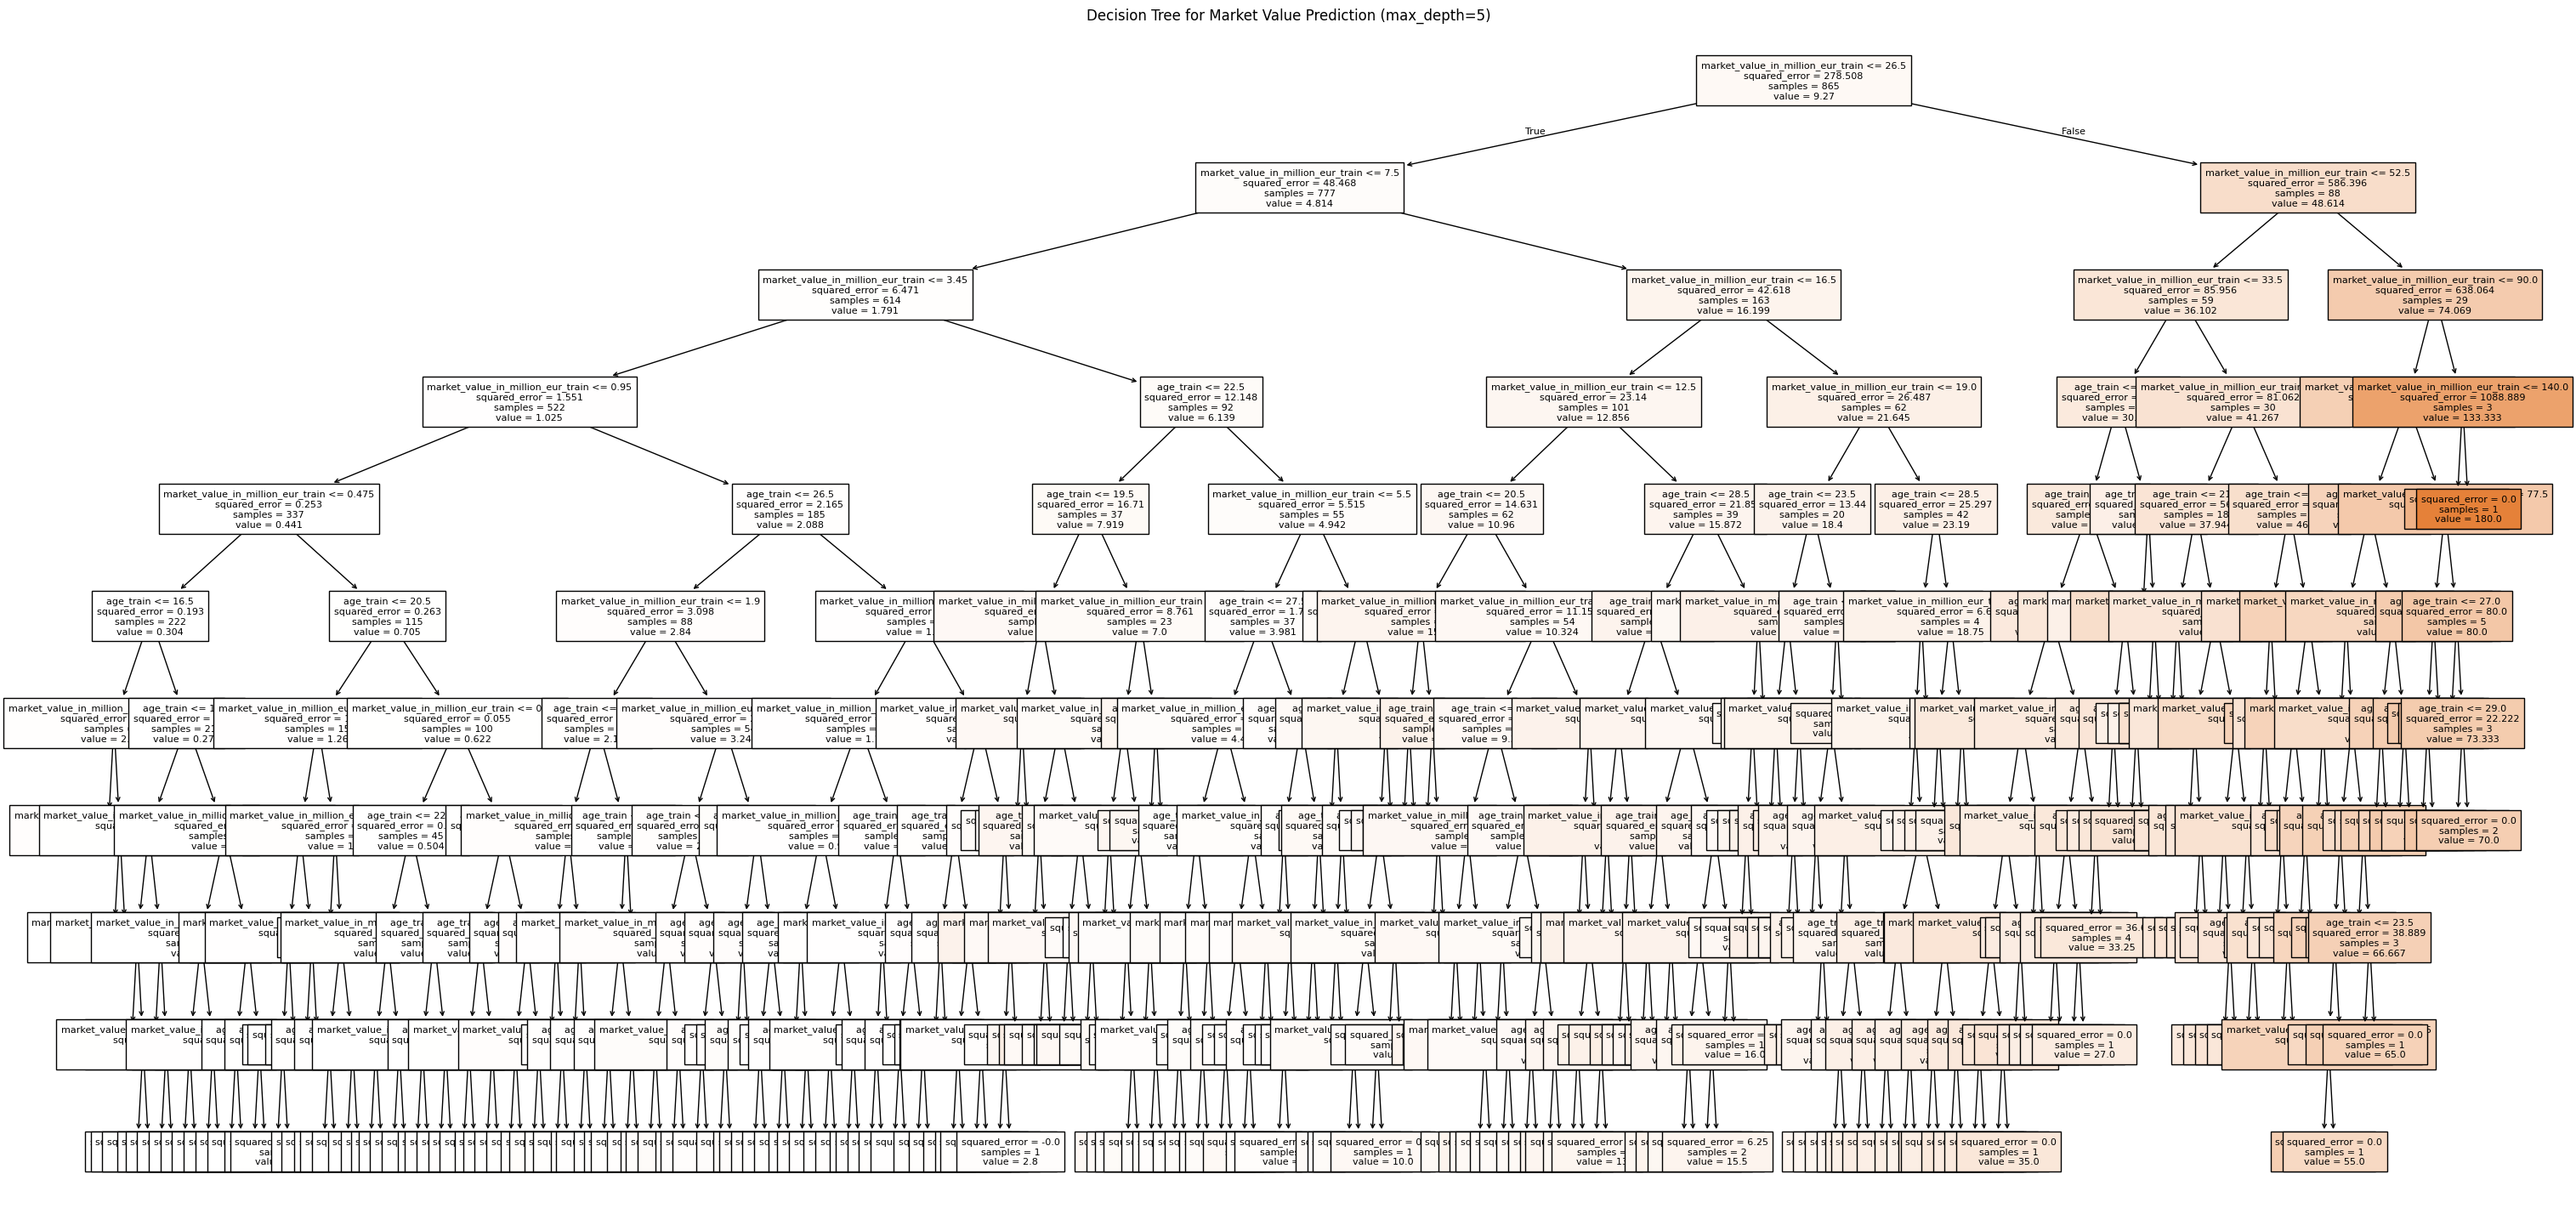

In [219]:


plt.figure(figsize=(36, 18))
tree.plot_tree(regressor, feature_names=features, filled=True, fontsize=8)
plt.title("Decision Tree for Market Value Prediction (max_depth=5)")
plt.show()

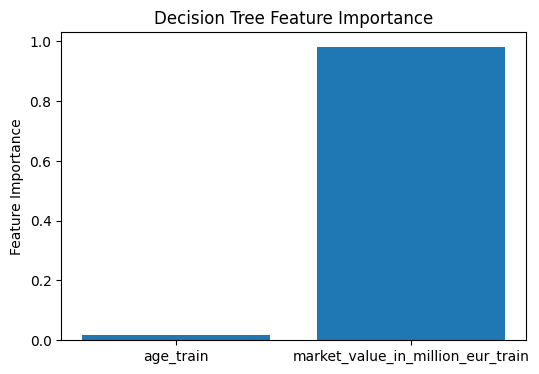

In [220]:
# Plot feature importance for the decision tree
feature_names = features
importances = regressor.feature_importances_

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances)
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

In [221]:
X_test["market_value_in_eur_test"] = y_test
X_test["prediction"] = y_pred

In [222]:
pdf_output = X_test.merge(pdf_test_train[["player_id", "name"]], left_index=True, right_index=True, how="left")

In [224]:
px.scatter(pdf_output, x="market_value_in_eur_test", y="prediction", title="Market Value Prediction vs Actual Values", hover_data=["name"])